<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/DataPreprocessing_5classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [2]:
def get_preprocess():
  deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/deliveries.jsonl', lines=True)
  sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/sessions.jsonl', lines=True)
  products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/products.jsonl', lines=True)
  users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/users.jsonl', lines=True)
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['delivery_weekday'] = deliveries['delivery_timestamp'].apply(lambda x: ls[x.weekday()])
  deliveries['delivery_day'] = deliveries['delivery_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['purchase_day'] = deliveries['purchase_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['diff_days'] = (deliveries['delivery_day'] - deliveries['purchase_day']).apply(lambda x: x.days)
  tmp = deliveries['diff_days']
  deliveries['purchase_morning'] = deliveries['purchase_timestamp'].apply(lambda x: 1 if x.hour<=14 else 0)
  all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
  all_info = all_info.merge(users, on='user_id', how='left')
  dec_var = ["delivery_company", 'diff_days', 'purchase_morning', 'city', 'delivery_weekday']
  all_info = all_info[dec_var]
  city_dum = pd.get_dummies(all_info['city'], drop_first=True)
  weekday_dum = pd.get_dummies(all_info['delivery_weekday'], drop_first=True)
  delivery_company_dum = pd.get_dummies(all_info['delivery_company'], drop_first=True)
  delivery_company_dum = delivery_company_dum.rename(columns={360:'delivery_360', 254:'delivery_254', 516:'delivery_516', 620:'delivery_620'})
  all_info.drop('delivery_company', axis=1, inplace=True)
  all_info.drop('city', axis=1, inplace=True)
  all_info.drop('delivery_weekday', axis=1, inplace=True)
  final = pd.concat([all_info, city_dum, delivery_company_dum, weekday_dum], axis=1)
  return final.drop('diff_days', axis=1), final['diff_days'], tmp

In [3]:
X, y, tmp = get_preprocess()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


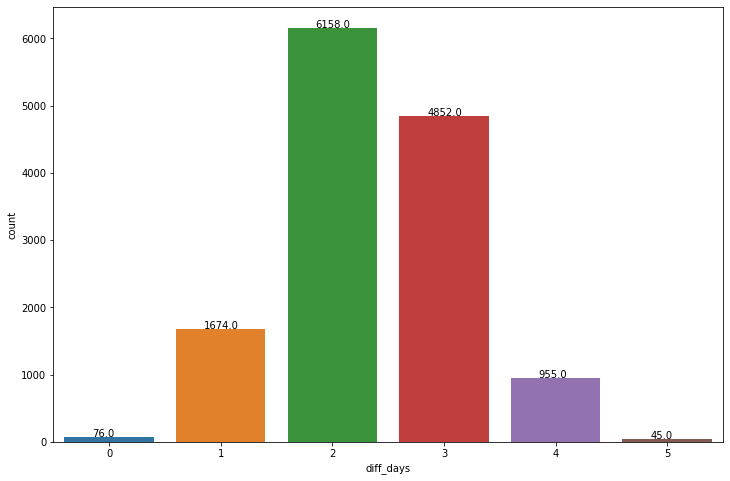

In [4]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [ ]:
X

,purchase_morning,Kraków,Poznań,Radom,Szczecin,Warszawa,Wrocław,delivery_360,delivery_516,delivery_620,monday,saturday,thursday,tuesday,wednesday
0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13755,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
13756,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13757,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13758,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## **Logistic Regression**

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pre = model.predict(X_test)

In [8]:
cm = confusion_matrix(y_test, y_pre)

In [9]:
print(cm)

[[   0   20    0    0    0    0]
 [   0  303  235    8    0    0]
 [   0  131 1429  441    4    0]
 [   0    8  479 1113   28    0]
 [   0    0   13  268   50    0]
 [   0    0    0    6    5    0]]


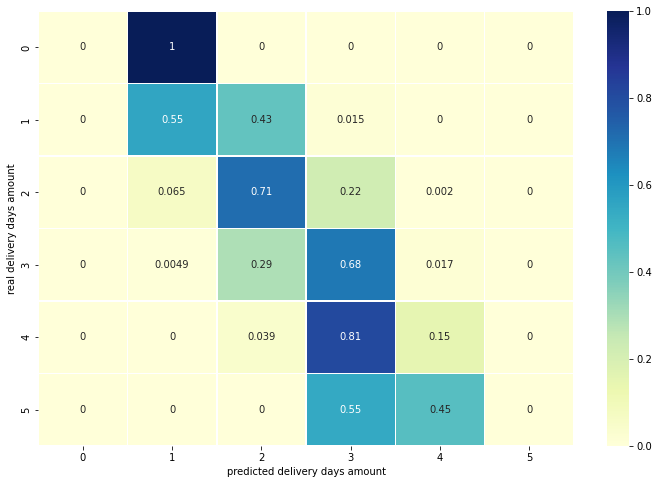

In [15]:

cm2 = confusion_matrix(y_test, y_pre, normalize='true')
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Jak widać na powyższym wykresie model kompletnie nie radzi sobie z przewidywaniem dostaw dostarczonych tego samego dnia oraz tych, które zostały dostarczone 5 dni po złożeniu zamówienia. Z wykresu widać, że wszystkie zamówienia, które zostały dostarczone i złożone tego samego dnia zostały zaklasyfikowane jako następny dzień dostawy, więc różnica nie przekracza 1 dnia. W przypadku zamówień dostarczonych po 5 dniach są one mniej więcej w równych proporcjach mylone z tymi po 3 i 4 dniach, zatem predykcja również nie myli się mocno.
Dostawy tego samego dnia i po 5 dnaich są na tyle rzadkie oraz ich złe przewidzenie nie powoduje jakichś dużych strat dla firmy, zatem można założyć, że system nie przewiduje dostaw tego samego dnia i za 5 dni.